# Classification of Hypnotic Depth

In [1]:
%reload_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # force CPU usage
import mne

import torch
import keras
from pathlib import Path
import re
from sklearn.preprocessing import RobustScaler, StandardScaler
from scipy.signal import butter, sosfilt
from sklearn.model_selection import StratifiedGroupKFold, GroupShuffleSplit


# helper functions
def preprocess_data(data, baseline_mean):
    # Step 1: Baseline correction (subtract the mean of the first 0.5 seconds for each channel) 
    data_corrected = data - baseline_mean
    
    # Step 2: Robust Scaler (normalize using median and IQR)
    scaler = RobustScaler()
    data_scaled = scaler.fit_transform(data_corrected.T)
    
    # Step 3: Normalization (z-score normalization)
    normalizer = StandardScaler()
    data_normalized = normalizer.fit_transform(data_scaled).T  # Transpose for sklearn, then back
    
    # Step 4: Clamp values greater than 20 standard deviations (becuause of the normalization at the previous step sd is 1)
    std_threshold = 20
    data_clamped = np.clip(data_normalized, -std_threshold, std_threshold)
    
    return data_clamped

def get_averaged_data(data):
    ''' Average over specific brain areas and return a new dataarray '''
    ba_patches = {'LF': ['Fp1', 'F3', 'F7', 'AF3', 'F1', 'F5'],
                  'LC': ['C3', 'T7', 'FC1', 'FC3', 'FC5', 'C1', 'C5', 'FT7'],
                  'LP': ['P3', 'P7', 'CP1', 'CP3', 'CP5', 'TP7', 'P1', 'P5'],
                  'LO': ['O1', 'PO3'],
                  'RF': ['Fp2', 'F4', 'F8', 'AF4', 'F2', 'F6'],
                  'RC': ['C4', 'T8', 'FC2', 'FC4', 'FC6', 'C2', 'C6', 'FT8'],
                  'RP': ['P4', 'P8', 'CP2', 'CP4', 'CP6', 'TP8', 'P2', 'P6'],
                  'RO': ['O2', 'PO4'],
                  'FZ': ['Fz', 'Fpz'],
                  'CZ': ['Cz'],
                  'PZ': ['Pz', 'CPz'],
                  'OZ': ['POz', 'Oz', 'Iz']}
    # average over each brain area patch and save in a new empty dataset
    C, S, T, ses = len(ba_patches), data.sizes.get('subject'), data.sizes.get('time'), 4
    data_numpy = np.zeros([S, ses, C, T])
    for i, (v) in enumerate(ba_patches.values()):
        data_numpy[:, :, i, :] = data.sel(channel=v).mean(dim='channel').values
    return data_numpy, list(ba_patches.keys())

def transform_labels(y, n_classes=4):
    """
    Transform the labels into a threshold-based format.
    For a score y, returns a vector indicating if it surpasses each threshold.
    """
    transformed = np.zeros((len(y), n_classes)) 
    for i, val in enumerate(y):
        transformed[i, :val] = 1
    return transformed

/opt/homebrew/Caskroom/miniforge/base/envs/EEGModalNet/lib/python3.11/site-packages/mne/externals/tempita/__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


## DATA

In [3]:
EEG_data_path = Path('/Volumes/Extreme SSD/PhD/OTKA study1/EEG data/BIDS/')

all_data = {}

# is it because of the resampling that there are different number of timepoints?

for root in sorted(EEG_data_path.glob('sub-*')):
    sub_path  = root / 'ses-01/eeg/'
    for data_path in sorted(sub_path.glob('*_eeg.vhdr')):
        bids_id, task = re.match(r'.*/sub-(.*)_ses-01_task-(.*)_eeg.vhdr', str(data_path)).groups()
        if task == 'baseline1':
            print(f'>>>>>>Processing {bids_id} {task}')
            epoch = mne.io.read_raw_brainvision(data_path, verbose=False, eog=['EOG1', 'EOG2'], misc=['ECG'])
            epoch.pick(picks='eeg', exclude=['M1', 'M2'])
            epoch.resample(128)
            epoch = epoch.get_data()
            baseline_mean = epoch.mean(axis=1, keepdims=True)
            continue
    
        if task.__contains__('experience'):
            print(f'>>>>>>Processing {bids_id} {task}')
            epoch = mne.io.read_raw_brainvision(data_path, verbose=False, eog=['EOG1', 'EOG2'], misc=['ECG'])
            epoch.pick(picks='eeg', exclude=['M1', 'M2'])
            epoch.resample(128)
            data = epoch.get_data()
            data_clamped = preprocess_data(data, baseline_mean)
            all_data[f'sub-{bids_id}_{task}'] = data_clamped

In [4]:
## Prepare the data to be converted and stored as a data array

# trim all the data in the dictionary to the minimum length
min_len = min([i.shape[1] for i in list(all_data.values())])
all_data = {k: v[:, :min_len] for k, v in all_data.items()}

# there are two missing tasks for sub-52, we fill them with zeros so th
all_data['sub-52_experience2'] = np.zeros_like(all_data['sub-52_experience1'])
all_data['sub-52_experience3'] = np.zeros_like(all_data['sub-52_experience1'])
data = np.array(list(all_data.values()))
data = data.reshape(52, 4, 56, -1)  # 52 subjects, 4 conditions, 56 channels, time
# rearranging the data for the last participant whose experience 2 and 3 data is missing
data[-1, -1] = data[-1, -3]  
data[-1, -3] = data[-1, -2]

data = xr.DataArray(data, 
                    dims=('subject', 'tasks', 'channel', 'time'),
                    coords={'subject': np.unique([i.split('_')[0] for i in all_data.keys()]),
                            'tasks': ['experience1', 'experience2', 'experience3', 'experience4'],
                            'channel': epoch.ch_names,
                            'time': np.arange(min_len)}
                            )

# data.to_netcdf('/Users/yeganeh/Codes/otka_data/EEG/experiment_EEG_data.nc5', engine='h5netcdf')

ValueError: min() arg is an empty sequence

## Xy

In [2]:
# open EEG and session data
EEG_data = xr.open_dataarray('/Users/yeganeh/Codes/otka_data/EEG/experiment_EEG_data.nc5')
session_data = pd.read_csv('/Users/yeganeh/Codes/otka_data/behavioral/behavioral_data.csv')
self_report = pd.read_csv('data/OTKA/embedded_text_emb_3_small.csv')
session_data['cluster_label'] = self_report['cluster_KMeans']

time_dim = 512
filtering = True
only_labelled_hypnosis = True
channels = ['Oz', 'Fz', 'Cz', 'Pz', 'Fp1', 'Fp2', 'F1', 'F2']
average_over_channels = True
output_head = 'cluster_labels'  # 'score' or 'binary_scores' or 'gpt_classification'
n_classes = 2

if average_over_channels:
    X_input, channels = get_averaged_data(EEG_data)
else:
    X_input = EEG_data.sel(channel=channels).to_numpy()

# including only hypnosis sessions
if only_labelled_hypnosis:
    print('>>>>> Including only labelled hypnosis sessions')
    session_data = session_data.query('description == "hypnosis"')[['bids_id', 'score', 'session', 'gpt_classification', 'cluster_label']].set_index('bids_id')
    X_input_hyp =  np.zeros([52, 2, len(channels), X_input.shape[-1]])
    for i in range(X_input.shape[0]):
        ses = session_data.loc[i+1, 'session'].values - 1
        X_input_hyp[i] = X_input[i, ses, :, :]
    X_input = X_input_hyp
    del X_input_hyp

# preparing x
if filtering:
    sos = butter(4, 1, btype='high', fs=128, output='sos')
    X_input = sosfilt(sos, X_input, axis=-1)

X_input = torch.tensor(X_input.squeeze()).unfold(-1, time_dim, time_dim).permute(0, 1, 3, 4, 2).flatten(0, 1)

# remove missing sessions for sub-52 depending on which sessions are included
remove_sess = -2 if only_labelled_hypnosis else [-2, -3]
X_input = np.delete(X_input, remove_sess, axis=0)
remove_ind = 102 if only_labelled_hypnosis else [205, 206]
session_data = session_data.reset_index().drop(index=102)  # TODO: does this also work for the condition when only labelled hypnosis == False?

# prepare y
if output_head == 'gpt_classification':
    y = session_data['gpt_classification'].apply(lambda x: 0 if x == 'no hypnosis' else 1 if x == 'shallow hypnosis' else 2)

elif output_head == 'ordinal_scores':
    y = session_data['score'].apply(lambda x: 0 if x <= 1 else 1 if x<7 else 2)

elif output_head == 'binary_scores':
    med = session_data['score'].median()
    y = session_data['score'].apply(lambda x: 0 if x>=med else 1)  # TODO: when we include only hypnosis sessions, we need to remove the equal sign to get more balanced classes

elif output_head == 'cluster_labels':
    y = session_data['cluster_label']

groups = session_data['bids_id'].values
y = y.values

>>>>> Including only labelled hypnosis sessions


In [57]:
y = session_data['cluster_label']
y = y.values

In [3]:
# prepare Kfold cross validation
cross_val = True

if cross_val:
    n_splits = 3
    group_kfold = StratifiedGroupKFold(n_splits=n_splits)
    train_val_splits = []
    for train_idx, val_idx in group_kfold.split(X_input, y, groups=groups):
        train_val_splits.append((train_idx, val_idx))

    # make sure that the splits are stratified and ther is a balance between the classes
    for train_idx, val_idx in train_val_splits:
        print(np.unique(y[train_idx], return_counts=True)[1] / len(y[train_idx]), np.unique(y[val_idx], return_counts=True)[1] / len(y[val_idx]))

else:
    group_shuffle = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)  # random state == 9
    train_idx, val_idx = next(group_shuffle.split(X_input, y, groups=groups))
    print(np.unique(y[train_idx], return_counts=True)[1] / len(y[train_idx]), np.unique(y[val_idx], return_counts=True)[1] / len(y[val_idx]))

[0.52173913 0.47826087] [0.52941176 0.47058824]
[0.52173913 0.47826087] [0.52941176 0.47058824]
[0.52941176 0.47058824] [0.51428571 0.48571429]


In [4]:
import torch.nn.functional as F

if output_head == 'gpt_classification':
    y = F.one_hot(torch.tensor(y), num_classes=3).float()
    y = y.reshape(-1, 1, 3).repeat(1, X_input.shape[1], 1)

elif output_head == 'ordinal_scores':
    y = transform_labels(y, n_classes=n_classes)
    y = torch.tensor(y).unsqueeze(1).repeat(1, X_input.shape[1], 1)

else:
    y = torch.tensor(y).reshape(-1, 1).repeat(1, X_input.shape[1])

## MODEL

In [5]:
# model
from src.EEGModalNet.models.common import ResidualBlock
import keras
from keras import layers
from keras import regularizers
from keras import ops
l2_lambda = 0.01
dropout_rate = 0.4

class BiasLayer(keras.layers.Layer):
    def __init__(self, units, *args, **kwargs):
        super(BiasLayer, self).__init__(*args, **kwargs)
        self.bias = self.add_weight(shape=[units],
                                    initializer='zeros',
                                    trainable=True)

    def call(self, x):
        return x + self.bias

class Critic(keras.Model):
    def __init__(self, time_dim, feature_dim, use_sublayer, n_classes=1, task='ordinal_reg'):
        super(Critic, self).__init__()

        self.input_shape = (time_dim, feature_dim)
        self.use_sublayer = use_sublayer

        self.model = keras.Sequential([
            keras.Input(shape=self.input_shape),
            ResidualBlock(feature_dim * 4, 5, activation='relu'),
            layers.Conv1D(2, 5, padding='same', activation='relu', name='conv3', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Conv1D(1, 5, padding='same', activation='relu', name='conv4', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Flatten(name='dis_flatten'),
            layers.Dense(512, name='dis_dense1', activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Dropout(dropout_rate),
            layers.Dense(128, name='dis_dense2', activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Dropout(dropout_rate),
            layers.Dense(32, name='dis_dense3', activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Dropout(dropout_rate),
            layers.Dense(8, name='dis_dense4', activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Dropout(dropout_rate),
            layers.Dense(n_classes, name='dis_dense5', activation='sigmoid', kernel_regularizer=regularizers.L2(l2_lambda))
        ], name='critic')

        # if task == 'ordinal_reg':
        #     self.output_layer = keras.Sequential([layers.Dense(n_classes),
        #                                         BiasLayer(n_classes),
        #                                         layers.Activation('sigmoid')])
        # else:
        #     self.output_layer = keras.Sequential([layers.Dense(n_classes, activation='sigmoid')])
    
    def call(self, inputs):
        return self.model(inputs)

# custom loss function for ordinal regression
def ordinal_loss(y_true, y_pred):
    y_true = ops.cast(y_true, dtype='float32')
    return ops.mean(ops.binary_crossentropy(y_true, y_pred))

def build_model(n_classes=n_classes, task='binary_reg', loss=ordinal_loss):
    model = Critic(time_dim=512, feature_dim=len(channels), use_sublayer=False, n_classes=n_classes, task=task)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=loss, metrics=['accuracy'])
    return model

In [6]:
n_epochs = 20
if cross_val:
    all_val_acc = []
    all_acc = []
    all_loss = []
    all_val_loss = []

    for i in range(n_splits):
        print(f'>>>>>> Fold {i+1}')
        torch.cuda.empty_cache() # clear GPU memory before training
        model = build_model(n_classes=1, task='binary_reg', loss='binary_crossentropy')
        train_idx, val_idx = train_val_splits[i]
        history = model.fit(X_input[train_idx].flatten(0, 1), y[train_idx].flatten(0, 1),
                            epochs=n_epochs,
                            batch_size=64,
                            validation_data=(X_input[val_idx].flatten(0, 1), y[val_idx].flatten(0, 1)))

        all_val_acc.append(history.history['val_accuracy'])
        all_acc.append(history.history['accuracy'])
        all_loss.append(history.history['loss'])
        all_val_loss.append(history.history['val_loss'])

        # # save the model
        # model.save(f'data/trainings/training_19092024/cv/model_{i+1}.model.keras')

else:
    model = build_model(n_classes=1, task='binary_reg', loss='binary_crossentropy')
    history = model.fit(X_input[train_idx].flatten(0, 1), y[train_idx].flatten(0, 1),
                        epochs=n_epochs,
                        batch_size=64,
                        validation_data=(X_input[val_idx].flatten(0, 1), y[val_idx].flatten(0, 1)))

>>>>>> Fold 1
Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5288 - loss: 4.5116 - val_accuracy: 0.5294 - val_loss: 0.8735
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.5740 - loss: 0.7962 - val_accuracy: 0.6688 - val_loss: 0.7273
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.7847 - loss: 0.6142 - val_accuracy: 0.6394 - val_loss: 0.8115
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.8172 - loss: 0.5558 - val_accuracy: 0.6852 - val_loss: 0.6570
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.8285 - loss: 0.5243 - val_accuracy: 0.6493 - val_loss: 0.7794
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.8466 - loss: 0.4736 - val_accuracy: 0.6629 - val_loss: 0.7344
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.8599 - loss: 0.4406 - val_accuracy: 0.6366 - val_loss: 0.7873
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.8811 - loss: 0.4

Text(0.5, 1.0, 'Loss')

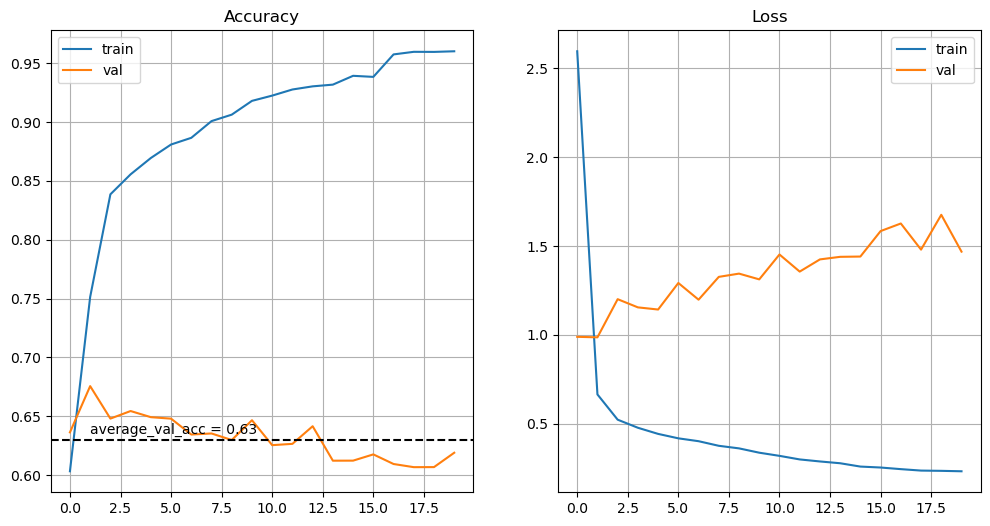

In [19]:
# visualize the accuaracy and loss

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.mean(all_acc, axis=0), label='train')
plt.plot(np.mean(all_val_acc, axis=0), label='val')
plt.legend()
plt.grid()
plt.axhline(0.63, color='black', linestyle='--')
plt.text(1, 0.635, 'average_val_acc = 0.63', color='black')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(np.mean(all_loss, axis=0), label='train')
plt.plot(np.mean(all_val_loss, axis=0), label='val')
plt.legend()
plt.grid()
plt.title('Loss')

In [40]:
chance = np.random.normal(0.5, 0.03, 60)
chance.shape

(60,)

In [39]:
np.hstack(np.array(all_val_acc)).std()

0.036041433671573836

Text(0.5, 1.0, 'Validation accuracy distribution')

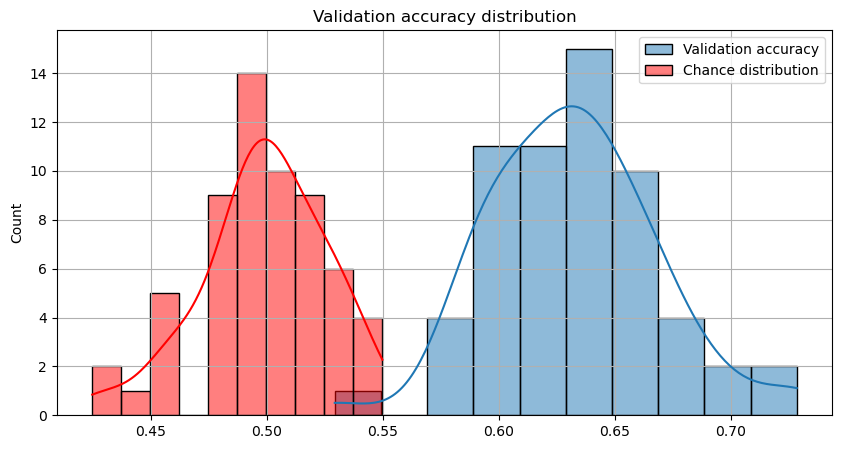

In [44]:
# histograph of the validation accuracy
plt.figure(figsize=(10, 5))
sns.histplot(np.hstack(np.array(all_val_acc)), bins=10, kde=True, label='Validation accuracy')
sns.histplot(chance, bins=10, kde=True, color='red', label='Chance distribution')
plt.legend()
plt.grid()
plt.title('Validation accuracy distribution')

In [51]:
np.array(all_val_acc).mean(axis=1)

array([0.47649573, 0.68084936])

In [45]:
np.array(all_val_acc).mean()

0.5921251773834229

### evaluate

In [134]:
def predict_rating(model, X):
    preds = model.predict(X)
    return np.sum(preds > 0.5, axis=-1)  # Count how many thresholds were surpassed (predicted probability > 0.5)

y_pred = predict_rating(model, X_input[val_idx].flatten(0, 1))
y_true = ops.sum(ops.cast(y[val_idx].flatten(0, 1), dtype='float32'), axis=-1).cpu()

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [118]:
np.unique(torch.sum(y[train_idx], axis=-1)[:, 0], return_counts=True)[1]/206

array([0.25242718, 0.30097087, 0.23300971])

In [135]:
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

0.2504370629370629
              precision    recall  f1-score   support

         0.0       0.20      0.17      0.19      1352
         1.0       0.28      0.28      0.28      1872
         2.0       0.25      0.30      0.27      1352

    accuracy                           0.25      4576
   macro avg       0.24      0.25      0.24      4576
weighted avg       0.25      0.25      0.25      4576



### Distribution

In [37]:
# save model & model config
model_path = 'data/trainings/training_19092024/'
model_name = 'HD_classify_'+ '8_channels'
model.save(model_path+f'{model_name}.model.keras')
model_config = model.model.get_config()
import json
with open(f'{model_name}_config.json', 'w') as f:
    json.dump(model_config, f)

In [123]:
# results
df = pd.read_csv('logs/history.csv', index_col=0)
df2 = pd.read_csv('logs/history_last3folds.csv', index_col=0).iloc[300:600]

df = df.drop(df.index[-1000:])

df_new = pd.DataFrame()

for i in range(3):
    df_new = pd.concat([df_new, df.iloc[i*500:i*500+300]], axis=0)

df_new = pd.concat([df_new, df2], axis=0).reset_index(drop=True)

Text(0.5, 1.0, 'Cross-Validated Accuracy Distribution')

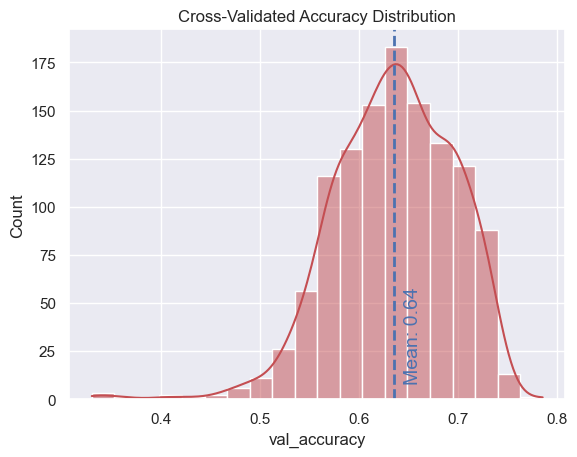

In [141]:
import seaborn as sns
sns.set_theme(style='darkgrid')
sns.histplot(df_new['val_accuracy'], bins=20, kde=True, color='r', label='Validation Accuracy')
# plot a vertical line at the mean.
plt.axvline(df_new['val_accuracy'].mean(), color='b', linestyle='dashed', linewidth=2)
# add the mean value to the plot.
plt.text(df_new['val_accuracy'].mean() + 0.01, 10, f'Mean: {df_new["val_accuracy"].mean():.2f}', rotation=90, color='b', fontsize=14)
plt.title('Cross-Validated Accuracy Distribution')

## Interpretablity Techniques

In [11]:
# open model
model = Critic(time_dim=512, feature_dim=len(channels), use_sublayer=False)
model.load_weights('logs/model_2.model.keras')

In [42]:
import numpy as np
import torch
from torch.autograd import grad

# Integrated Gradients function
def integrated_gradients(model, inputs, target_class, baseline=None, steps=50):
    if baseline is None:
        # Set the baseline to zero (same shape as input)
        baseline = torch.zeros_like(inputs)
    
    # Scale inputs and compute gradients at each interpolation point
    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(steps + 1)]
    scaled_inputs = torch.stack(scaled_inputs).flatten(0, 1).requires_grad_(True)
    
    # Initialize attributions
    total_gradients = torch.zeros_like(inputs)
    
    for scaled_input in scaled_inputs:
        # Perform forward pass
        output = model(scaled_input.unsqueeze(0))  # Add batch dimension
        target = output[:, target_class]  # Extract the logit for the target class
        
        # Compute gradients
        grads = grad(target, scaled_input, retain_graph=True)[0]
        total_gradients += grads
    
    # Average gradients over all steps
    avg_gradients = total_gradients / steps
    
    # Compute the attributions
    attributions = (inputs - baseline) * avg_gradients
    return attributions.detach().cpu().numpy()


In [28]:
sample_idx = 0
eeg_sample = torch.tensor(X_input_hyp[train_ids].flatten(0, 1)[sample_idx], dtype=torch.float32).unsqueeze(0) 
eeg_sample.shape

/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_69344/1547276079.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eeg_sample = torch.tensor(X_input_hyp[train_ids].flatten(0, 1)[sample_idx], dtype=torch.float32).unsqueeze(0)


torch.Size([1, 512, 8])

/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_69344/3518009999.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eeg_sample = torch.tensor(X_input_hyp[test_ids].flatten(0, 1)[sample_idx], dtype=torch.float32).unsqueeze(0)  # Add batch dimension


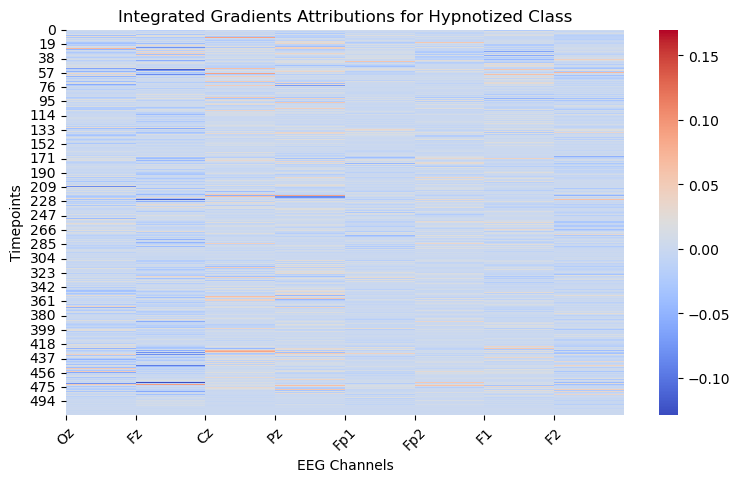

In [64]:
# Load the Keras model
model = Critic(time_dim=512, feature_dim=len(channels), use_sublayer=False)
model.load_weights('logs/model_2.model.keras')


# Select a sample from your test data
sample_idx = 0
eeg_sample = torch.tensor(X_input_hyp[test_ids].flatten(0, 1)[sample_idx], dtype=torch.float32).unsqueeze(0)  # Add batch dimension

# Call Integrated Gradients function
attributions = integrated_gradients(model, eeg_sample, target_class=0)  # Assuming 1 is the hypnotized class

# Visualize or interpret the attributions as needed
import matplotlib.pyplot as plt
import seaborn as sns

# Example of visualizing the attributions as a heatmap
plt.figure(figsize=(9, 5))
sns.heatmap(attributions.squeeze(), cmap='coolwarm', cbar=True)
plt.title('Integrated Gradients Attributions for Hypnotized Class')
plt.xlabel('EEG Channels')

# include the channels labels in the x-axis
plt.xticks(ticks=np.arange(len(channels)), labels=channels, rotation=45)
plt.ylabel('Timepoints')
plt.show()


In [ ]:
test_set = X_input_hyp[test_ids].flatten(0, 1)
all_attributions = []

for sample in test_set[:10]:  # Loop over all EEG samples
    attributions = integrated_gradients(model, sample, target_class=0)  # Get attributions for each sample
    all_attributions.append(attributions)

# Convert the list to a NumPy array for easier averaging
all_attributions = np.array(all_attributions)

# Average attributions over all samples
avg_attributions = np.mean(all_attributions, axis=0)

## Gender Classification Using OTKA data

In [41]:
# gender data (y)
one_hot_encoding = False

gender = pd.read_excel('/Users/yeganeh/Codes/SugNet/data/PLB_HYP_data_MASTER.xlsx')[['bids_id', 'gender']].dropna().set_index('bids_id')
gender['gender'] = gender['gender'].apply(lambda x: 1 if x == 'Female' else 0)
y_ = gender['gender'].values.repeat(4)[:-2]  # repeat for the 4 sessions and remove the last two entries because the last two sessions are missing for the last participant

# subject ids for grouped cross validation
groups = gender.index.to_numpy() - 1
groups = groups.repeat(4)[:-2]

In [74]:
# X
EEG_data = xr.open_dataarray('data/OTKA/experiment_EEG_data.nc5')

n_subject = 52
time_dim = 512
filtering = True
average_channels = True
channels = ['Oz', 'Fz', 'Cz', 'Pz', 'Fp1', 'Fp2', 'F1', 'F2']

if average_channels:
    X_input, channels = get_averaged_data(EEG_data)
else:
    X_input = EEG_data.sel(subject=EEG_data.subject[:n_subject], channel=channels).to_numpy()

# remove placeholder data (zeros) from the missing sessions of the last participant 
X_input = torch.tensor(X_input).flatten(0, 1)
X_sub52_ses4 = X_input[-1].unsqueeze(0)
X_input = X_input[:-3]
X_input = torch.cat([X_input, X_sub52_ses4], dim=0)

# preparing x
if filtering:
    sos = butter(4, 1, btype='high', fs=128, output='sos')
    X_input = sosfilt(sos, np.array(X_input), axis=-1)

X_input = torch.tensor(X_input).unfold(-1, time_dim, time_dim).permute(0, 2, 3, 1)

In [86]:
# # one hot encoding of the gender data
if one_hot_encoding:
    y = np.eye(2)[y_].astype(int)
    y = torch.tensor(y).reshape(-1, 1, 2).repeat(1, X_input.shape[1], 1)
else:
    y = torch.tensor(y_).reshape(-1, 1).repeat(1, X_input.shape[1])

In [87]:
# Train/test split
from sklearn.model_selection import StratifiedGroupKFold, GroupShuffleSplit
cross_val = False

if cross_val:
    n_splits = 3
    group_kfold = StratifiedGroupKFold(n_splits=n_splits)
    train_val_splits = []
    for train_idx, val_idx in group_kfold.split(np.array(X_input), y_, groups=groups):
        train_val_splits.append((train_idx, val_idx))
else:
    group_shuffle = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=2)  
    train_idx, val_idx = next(group_shuffle.split(np.array(X_input), y_, groups=groups))

np.unique(y[train_idx].flatten(0, 1), return_counts=True)[1] / len(y[train_idx].flatten(0, 1)), np.unique(y[val_idx].flatten(0, 1), return_counts=True)[1] / len(y[val_idx].flatten(0, 1))

(array([0.2345679, 0.7654321]), array([0.27272727, 0.72727273]))

### model

In [93]:
# model
from src.EEGModalNet.models.common import ResidualBlock
import keras
from keras import layers
from keras import regularizers
l2_lambda = 0.01
dropout_rate = 0.5

class Critic(keras.Model):
    def __init__(self, time_dim, feature_dim, use_sublayer):
        super(Critic, self).__init__()

        self.input_shape = (time_dim, feature_dim)
        self.use_sublayer = use_sublayer

        self.model = keras.Sequential([
            keras.Input(shape=self.input_shape),
            ResidualBlock(feature_dim * 4, 5, activation='relu'),
            layers.Conv1D(2, 5, padding='same', activation='relu', name='conv3', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Conv1D(1, 5, padding='same', activation='relu', name='conv4', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Flatten(name='dis_flatten'),
            layers.Dense(512, name='dis_dense1', activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Dropout(dropout_rate),
            layers.Dense(128, name='dis_dense2', activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Dropout(dropout_rate),
            layers.Dense(32, name='dis_dense3', activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Dropout(dropout_rate),
            layers.Dense(8, name='dis_dense4', activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Dropout(dropout_rate),
            layers.Dense(1, name='sigmoid', activation='sigmoid', kernel_regularizer=regularizers.L2(l2_lambda))
        ], name='critic')
    
    def call(self, inputs):
        return self.model(inputs)

def build_model():
    model = Critic(time_dim=512, feature_dim=len(channels), use_sublayer=False)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
if cross_val:
    k = 3
    n_epochs = 3
    all_val_acc = []
    all_acc = []
    all_loss = []
    all_val_loss = []

    for i in range(k):
        print(f'>>>>>> Fold {i+1}')
        model = build_model()
        train_idx, val_idx = train_val_splits[i]
        history = model.fit(X_input[train_idx].flatten(0, 1), y[train_idx].flatten(0, 1),
                            epochs=n_epochs,
                            batch_size=64,
                            validation_data=(X_input[val_idx].flatten(0, 1), y[val_idx].flatten(0, 1)))

        all_val_acc.append(history.history['val_accuracy'])
        all_acc.append(history.history['accuracy'])
        all_loss.append(history.history['loss'])
        all_val_loss.append(history.history['val_loss'])

else:
    model = build_model()
    history = model.fit(X_input[train_idx].flatten(0, 1), y[train_idx].flatten(0, 1),
                        epochs=40,
                        batch_size=64,
                        validation_data=(X_input[val_idx].flatten(0, 1), y[val_idx].flatten(0, 1)))

## Incorporating the free-response questions to the model

This section takes advanteges of the free-response self reports, participants provided about their hypnotic experience:
In this part, we first vectorize and then cluster the self-reports. later these cluster will be added as a seprated head to the model above so that we will train a multi-task model.

### text-clustering (topic-modeling)

In [1]:
import pandas as pd
session_data = pd.read_csv('/Users/yeganeh/Codes/otka_data/behavioral/behavioral_data.csv')
# session_data = session_data.query('description == "hypnosis"')[['bids_id', 'score', 'english_text']].set_index('bids_id')
self_reports = session_data.loc[:, 'english_text']

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Vectorizing text using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(self_reports)

# Clustering using k-means
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)

# # Print out cluster labels for each self-report
clusters = kmeans.labels_
# for i, report in enumerate(self_reports):
#     print(f"Report: {report} --> Cluster: {clusters[i]}")

np.unique(clusters, return_counts=True)[1] / len(clusters)

array([0.27884615, 0.47115385, 0.25      ])

### Sentiment Analysis

In [ ]:
from transformers import pipeline
classifier = pipeline('sentiment-analysis', device='mps')
classifier(self_reports[0])

### Zero-shot classification

In [7]:
import openai
import time
openai.api_key = "my_key"

In [ ]:
classifications = []

for i, report in enumerate(self_reports):
    prompt = f"Classify the following: '{report}'"

    try:
        # Use the chat completion endpoint
        response = openai.chat.completions.create(
            model="gpt-4o", 
            messages=[
                {"role": "system", "content": "You are a translator and a classifier that categorizes the depth of hypnosis based on self-reports written in Hungarian. Classify the following text into three categories: 'shallow hypnosis' or 'deep hypnosis'. be concise and clear."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=40,
            temperature=0  # Deterministic output
        )
        
        # Extract classification from response
        classification = response.choices[0].message.content.strip()
        classifications.append(classification)

        print(f"Processed report {i+1}/{len(self_reports)}: {classification}")

    except Exception as e:
        print(f"Error processing report {i+1}: {e}")
        classifications.append("Error")

    # time.sleep(1)  # avoid rate limiting

<Axes: xlabel='score', ylabel='Count'>

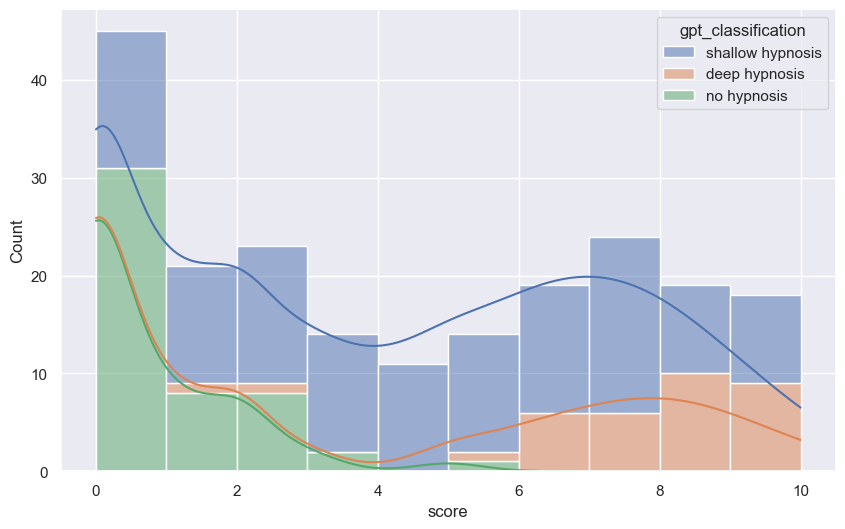

In [110]:
# plot participnats ratings against gpt_classification
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='darkgrid')
plt.figure(figsize=(10, 6))
sns.histplot(data=session_data, x='score', hue='gpt_classification', multiple='stack', bins=10, kde=True)

### Text embedding

In [ ]:
self_reports = session_data[['bids_id', 'english_text']].set_index('bids_id')

In [13]:
from openai import OpenAI
client = OpenAI(api_key="my_key")

def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

self_reports['ada_embedding'] = self_reports.english_text.apply(lambda x: get_embedding(x, model='text-embedding-3-small'))

In [ ]:
# Step 2: Cluster the embeddings using KMeans
embeddings = np.array(self_reports.ada_embedding.tolist())
def cluster_embeddings(embeddings, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)
    return kmeans.labels_

# Cluster the embeddings
cluster_labels = cluster_embeddings(embeddings, n_clusters=2)

self_reports['cluster'] = cluster_labels
self_reports['score'] = session_data['score']
# self_reports.to_csv('data/OTKA/embedded_text_emb_3_small.csv', index=False)

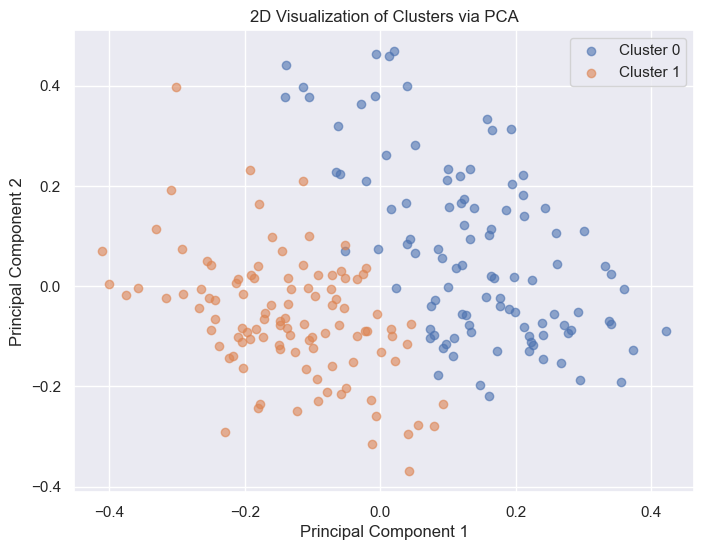

In [42]:
from sklearn.decomposition import PCA

# Step 1: Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings) 

def visualize_clusters(reduced_embeddings, cluster_labels):
    plt.figure(figsize=(8, 6))
    
    # Plot the points for each cluster
    for label in np.unique(cluster_labels):
        cluster_points = reduced_embeddings[cluster_labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {label}", alpha=0.6)
    
    plt.title("2D Visualization of Clusters via PCA")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.show()

# Step 2: Visualize the clusters with t-SNE
visualize_clusters(reduced_embeddings, cluster_labels)


### Investigate the characteristics of each cluster

In [ ]:
session_data = pd.read_csv('/Users/yeganeh/Codes/otka_data/behavioral/behavioral_data.csv')
session_data['cluster_label'] = self_reports['cluster_KMeans']

<Axes: xlabel='score', ylabel='Count'>

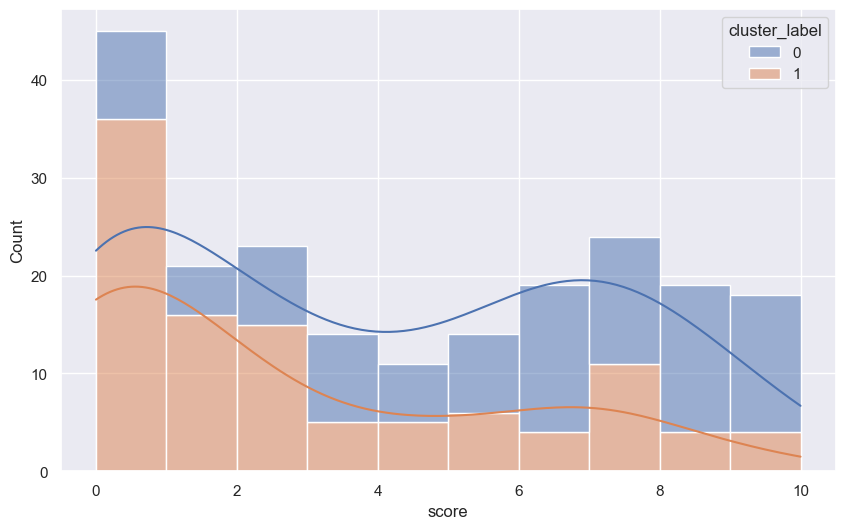

In [29]:
# visualize the clusters_labels
sns.set_theme(style='darkgrid')
plt.figure(figsize=(10, 6))
sns.histplot(data=session_data, x='score', hue='cluster_label', multiple='stack', bins=10, kde=True)

<Axes: xlabel='description', ylabel='Count'>

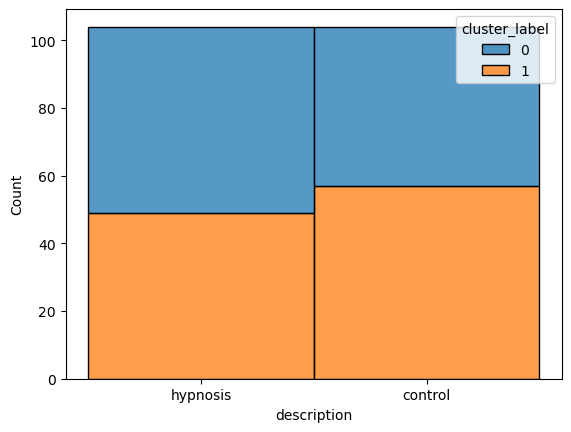

In [22]:
sns.histplot(data=session_data, x='description', hue='cluster_label', multiple='stack', bins=10)

<Axes: xlabel='procedure', ylabel='Count'>

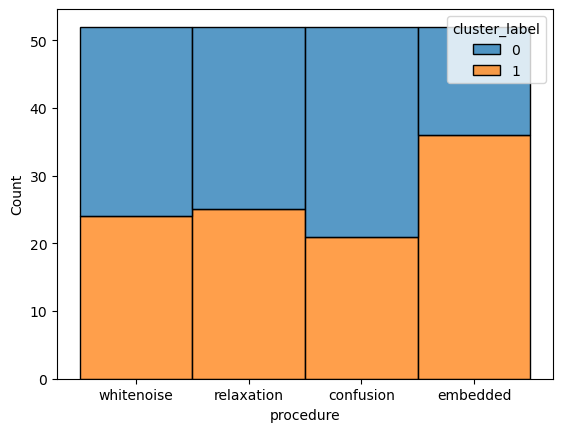

In [26]:
sns.histplot(data=session_data, x='procedure', hue='cluster_label', multiple='stack', bins=10)

<Axes: xlabel='gpt_classification', ylabel='Count'>

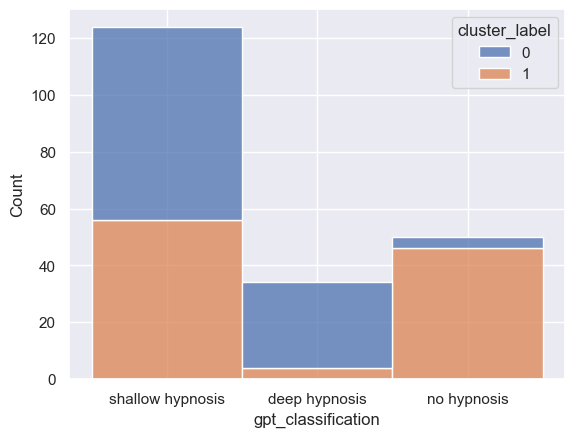

In [35]:
sns.histplot(data=session_data, x='gpt_classification', hue='cluster_label', multiple='stack', bins=10)

#### Topic model

In [27]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import ast

# Preprocess the text data for each cluster
texts_cluster_0 = self_reports.query('cluster_KMeans == 0')['english_text']
texts_cluster_1 = self_reports.query('cluster_KMeans == 1')['english_text']

# Vectorize the text data
vectorizer = CountVectorizer(stop_words='english')
X_0 = vectorizer.fit_transform(texts_cluster_0)
X_1 = vectorizer.fit_transform(texts_cluster_1)

# X_0 = self_reports.query('cluster_KMeans == 0')['ada_embedding'].values
# X_1 = self_reports.query('cluster_KMeans == 1')['ada_embedding'].values
# X_0 = np.array([ast.literal_eval(i) for i in X_0])
# X_1 = np.array([ast.literal_eval(i) for i in X_1])

# Fit LDA
lda_0 = LatentDirichletAllocation(n_components=2)
lda_0.fit(X_0)

lda_1 = LatentDirichletAllocation(n_components=2)
lda_1.fit(X_1)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display topics for both clusters
display_topics(lda_0, vectorizer.get_feature_names_out(), 10)  # Top 5 words for cluster 0
display_topics(lda_1, vectorizer.get_feature_names_out(), 10)  # Top 5 words for cluster 1

Topic 0:
ocean eliminating hurting agitated room returning reads fast eat forgot
Topic 1:
eliminating reads hurting ocean room easy caused couldn barely agitated
Topic 0:
feel didn eyes bit end felt little like noise mind
Topic 1:
felt didn time state feel relaxed bit relax previous hypnosis


#### Frequency Analysis

In [3]:
texts_cluster_0 = self_reports.query('cluster_KMeans == 0')['english_text']
texts_cluster_1 = self_reports.query('cluster_KMeans == 1')['english_text']

In [4]:
from collections import Counter

# Function to get word frequency
def get_word_frequencies(texts):
    words = ' '.join(texts).split()
    return Counter(words)

freq_0 = get_word_frequencies(texts_cluster_0)
freq_1 = get_word_frequencies(texts_cluster_1)

# Display most common words in each cluster
print("Most common words in cluster 0:", freq_0.most_common(10))
print("Most common words in cluster 1:", freq_1.most_common(10))

Most common words in cluster 0: [('I', 361), ('was', 215), ('a', 155), ('the', 134), ('and', 128), ('to', 111), ('my', 108), ('of', 87), ('in', 83), ('felt', 73)]
Most common words in cluster 1: [('I', 451), ('the', 295), ('was', 233), ('to', 208), ('a', 130), ('and', 120), ('my', 119), ('it', 96), ('that', 78), ('of', 75)]
